In [1]:
import clearml
from clearml import Dataset
from clearml import Task
from datetime import datetime
import tensorflow_addons as tfa

/opt/homebrew/Caskroom/miniforge/base/envs/env_tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/env_tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were 

In [2]:
name_append = datetime.now().strftime("%d_%m_%Y_%H")
model_name = f"mae" + "_" + name_append 
task = Task.create(project_name="RFI_mae", task_name=f"{model_name}")


In [3]:
import sys, os
sys.path.append('..')

import matplotlib.pyplot as plt
from src.mae import *
from src.mae.data._augment import *
from src.mae.CONSTANTS import *

In [4]:
data = Data()
data.load_data('../data/processed/train_zm_jsd.npy')

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-04-13 15:51:14.402781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-13 15:51:14.402911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Get a batch of images.
image_batch = next(iter(data.train_ds))

In [6]:
with tf.device('/cpu:0'):
    augmentation_model = get_train_augmentation_model()
    augmented_images = augmentation_model(image_batch)

(34, 50)
Index selected: 3.


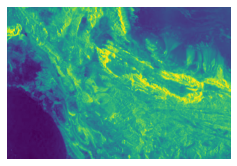

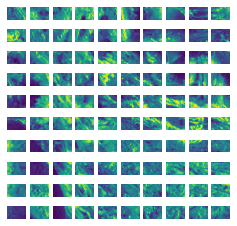

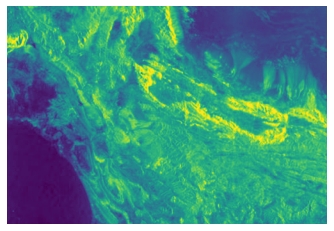

In [7]:
# Define the patch layer.
patch_layer = Patches()
# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image[:,:,1])
plt.axis("off")
plt.show()

In [8]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

number of patches  100


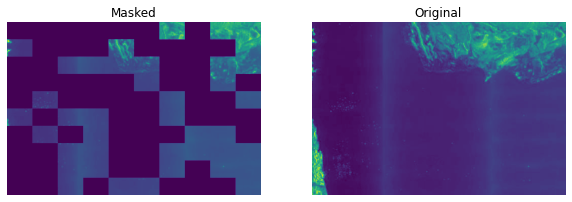

In [9]:
# Show a maksed patch image.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow((img[:,:,1]))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow((img[:,:,1]))
plt.axis("off")
plt.title("Original")
plt.show()

In [10]:

patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
encoder.summary()

(34, 50)
Model: "mae_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 128)   256         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, None, 128)   263808      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                               

In [11]:
decoder = create_decoder()
decoder.layers[-1].output_shape

(340, 500)


(None, 340, 500, 2)

In [12]:
mae_model = MaskedAutoencoder(
    train_augmentation_model=get_train_augmentation_model(),
    test_augmentation_model=get_test_augmentation_model(),
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [13]:
mae_model.encoder.summary()

Model: "mae_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 128)   256         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, None, 128)   263808      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                        

In [14]:
test_images = next(iter(data.train_ds))

In [15]:
from src.mae.models._callbacks import *
total_steps = int((len(data.train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]

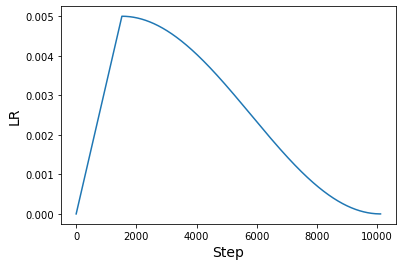

In [16]:

plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


In [17]:
train_callbacks = [TrainMonitor(epoch_interval=5,test_images=test_images)]

In [19]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"]
)

Epoch 1/100
number of patches  100


2023-04-13 15:52:04.821223: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-13 15:52:04.821641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 0.0427 - mae: 0.1578

2023-04-13 15:52:42.550850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Idx chosen: 6

0.2413444072008133
 tf.Tensor(0.2542528, shape=(), dtype=float32)


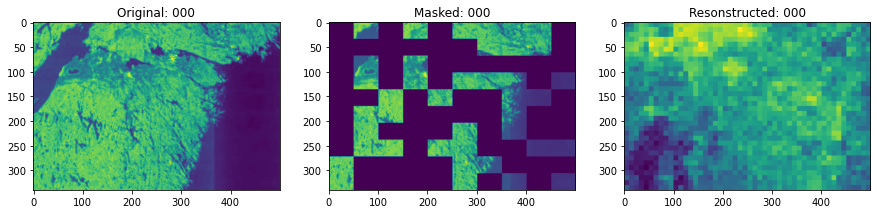

102/102 [==============================] - 56s 445ms/step - loss: 0.0427 - mae: 0.1578 - val_loss: 0.0288 - val_mae: 0.1300
Epoch 2/100
102/102 [==============================] - 40s 389ms/step - loss: 0.0306 - mae: 0.1320 - val_loss: 0.0401 - val_mae: 0.1543
Epoch 3/100
102/102 [==============================] - 43s 412ms/step - loss: 0.0304 - mae: 0.1302 - val_loss: 0.0335 - val_mae: 0.1359
Epoch 4/100
102/102 [==============================] - 50s 489ms/step - loss: 0.0297 - mae: 0.1291 - val_loss: 0.0287 - val_mae: 0.1230
Epoch 5/100
102/102 [==============================] - 34s 334ms/step - loss: 0.0279 - mae: 0.1247 - val_loss: 0.0277 - val_mae: 0.1247
Epoch 6/100
102/102 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.1171
Idx chosen: 0

0.37861713767051697
 tf.Tensor(0.39074, shape=(), dtype=float32)


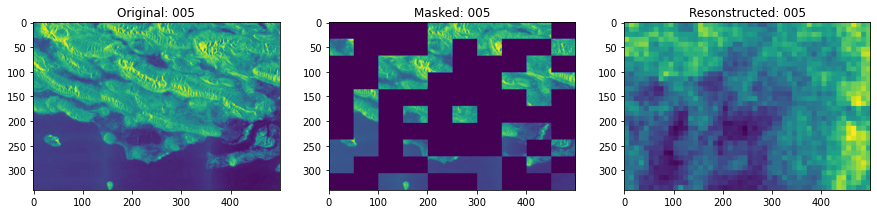

102/102 [==============================] - 39s 385ms/step - loss: 0.0247 - mae: 0.1171 - val_loss: 0.0344 - val_mae: 0.1346
Epoch 7/100
102/102 [==============================] - 53s 512ms/step - loss: 0.0272 - mae: 0.1246 - val_loss: 0.0245 - val_mae: 0.1137
Epoch 8/100
102/102 [==============================] - 30s 297ms/step - loss: 0.0226 - mae: 0.1118 - val_loss: 0.0255 - val_mae: 0.1162
Epoch 9/100
102/102 [==============================] - 31s 306ms/step - loss: 0.0202 - mae: 0.1047 - val_loss: 0.0351 - val_mae: 0.1406
Epoch 10/100
102/102 [==============================] - 32s 313ms/step - loss: 0.0181 - mae: 0.0981 - val_loss: 0.0168 - val_mae: 0.0963
Epoch 11/100
102/102 [==============================] - ETA: 0s - loss: 0.0166 - mae: 0.0937
Idx chosen: 4

0.48327916860580444
 tf.Tensor(0.43573672, shape=(), dtype=float32)


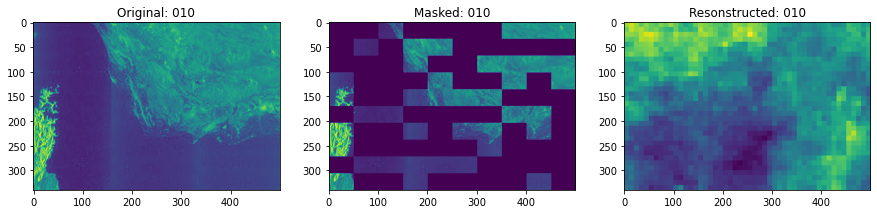

102/102 [==============================] - 32s 315ms/step - loss: 0.0166 - mae: 0.0937 - val_loss: 0.0158 - val_mae: 0.0911
Epoch 12/100
102/102 [==============================] - 40s 388ms/step - loss: 0.0148 - mae: 0.0872 - val_loss: 0.0143 - val_mae: 0.0864
Epoch 13/100
102/102 [==============================] - 39s 384ms/step - loss: 0.0131 - mae: 0.0812 - val_loss: 0.0111 - val_mae: 0.0729
Epoch 14/100
102/102 [==============================] - 47s 459ms/step - loss: 0.0131 - mae: 0.0814 - val_loss: 0.0113 - val_mae: 0.0752
Epoch 15/100
102/102 [==============================] - 36s 351ms/step - loss: 0.0111 - mae: 0.0737 - val_loss: 0.0104 - val_mae: 0.0699
Epoch 16/100
102/102 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0733
Idx chosen: 1

0.7664757370948792
 tf.Tensor(0.7657323, shape=(), dtype=float32)


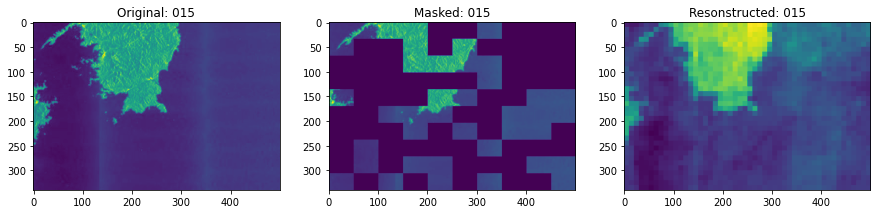

102/102 [==============================] - 58s 570ms/step - loss: 0.0109 - mae: 0.0733 - val_loss: 0.0098 - val_mae: 0.0684
Epoch 17/100
102/102 [==============================] - 34s 326ms/step - loss: 0.0103 - mae: 0.0706 - val_loss: 0.0097 - val_mae: 0.0677
Epoch 18/100
102/102 [==============================] - 34s 329ms/step - loss: 0.0094 - mae: 0.0665 - val_loss: 0.0089 - val_mae: 0.0649
Epoch 19/100
102/102 [==============================] - 33s 326ms/step - loss: 0.0096 - mae: 0.0677 - val_loss: 0.0094 - val_mae: 0.0659
Epoch 20/100
102/102 [==============================] - 38s 371ms/step - loss: 0.0089 - mae: 0.0648 - val_loss: 0.0083 - val_mae: 0.0619
Epoch 21/100
102/102 [==============================] - ETA: 0s - loss: 0.0086 - mae: 0.0633
Idx chosen: 7

0.6922870874404907
 tf.Tensor(0.68879795, shape=(), dtype=float32)


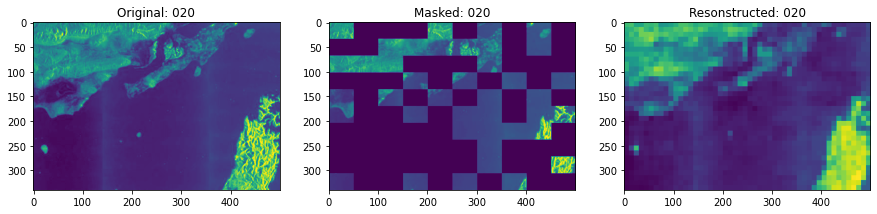

102/102 [==============================] - 31s 302ms/step - loss: 0.0086 - mae: 0.0633 - val_loss: 0.0082 - val_mae: 0.0610
Epoch 22/100
102/102 [==============================] - 31s 309ms/step - loss: 0.0083 - mae: 0.0620 - val_loss: 0.0084 - val_mae: 0.0626
Epoch 23/100
102/102 [==============================] - 31s 306ms/step - loss: 0.0085 - mae: 0.0630 - val_loss: 0.0083 - val_mae: 0.0623
Epoch 24/100
102/102 [==============================] - 34s 337ms/step - loss: 0.0082 - mae: 0.0623 - val_loss: 0.0077 - val_mae: 0.0595
Epoch 25/100
102/102 [==============================] - 41s 400ms/step - loss: 0.0080 - mae: 0.0611 - val_loss: 0.0079 - val_mae: 0.0608
Epoch 26/100
102/102 [==============================] - ETA: 0s - loss: 0.0077 - mae: 0.0598
Idx chosen: 8

0.8590685129165649
 tf.Tensor(0.8608975, shape=(), dtype=float32)


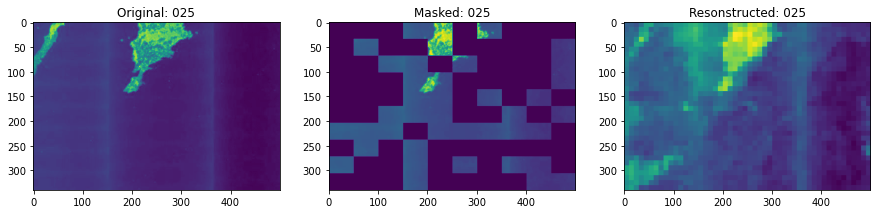

102/102 [==============================] - 39s 376ms/step - loss: 0.0077 - mae: 0.0598 - val_loss: 0.0078 - val_mae: 0.0600
Epoch 27/100
102/102 [==============================] - 43s 416ms/step - loss: 0.0080 - mae: 0.0612 - val_loss: 0.0079 - val_mae: 0.0607
Epoch 28/100
102/102 [==============================] - 53s 521ms/step - loss: 0.0075 - mae: 0.0588 - val_loss: 0.0076 - val_mae: 0.0599
Epoch 29/100
102/102 [==============================] - 36s 336ms/step - loss: 0.0075 - mae: 0.0586 - val_loss: 0.0071 - val_mae: 0.0567
Epoch 30/100
102/102 [==============================] - 36s 352ms/step - loss: 0.0073 - mae: 0.0577 - val_loss: 0.0070 - val_mae: 0.0570
Epoch 31/100
102/102 [==============================] - ETA: 0s - loss: 0.0077 - mae: 0.0593
Idx chosen: 6

0.4589022099971771
 tf.Tensor(0.4638323, shape=(), dtype=float32)


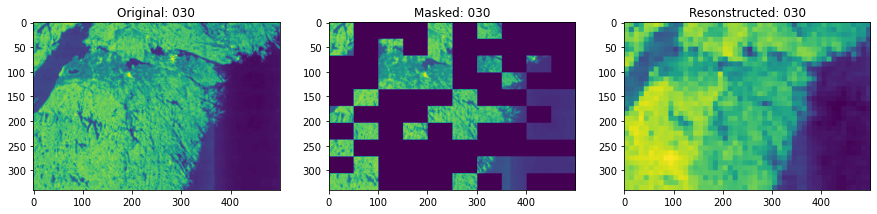

102/102 [==============================] - 46s 435ms/step - loss: 0.0077 - mae: 0.0593 - val_loss: 0.0070 - val_mae: 0.0565
Epoch 32/100
102/102 [==============================] - 30s 296ms/step - loss: 0.0073 - mae: 0.0578 - val_loss: 0.0070 - val_mae: 0.0565
Epoch 33/100
102/102 [==============================] - 32s 318ms/step - loss: 0.0071 - mae: 0.0565 - val_loss: 0.0074 - val_mae: 0.0572
Epoch 34/100
102/102 [==============================] - 32s 312ms/step - loss: 0.0071 - mae: 0.0571 - val_loss: 0.0068 - val_mae: 0.0556
Epoch 35/100
102/102 [==============================] - 39s 382ms/step - loss: 0.0069 - mae: 0.0560 - val_loss: 0.0068 - val_mae: 0.0542
Epoch 36/100
102/102 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0601
Idx chosen: 0

0.5111457109451294
 tf.Tensor(0.5169494, shape=(), dtype=float32)


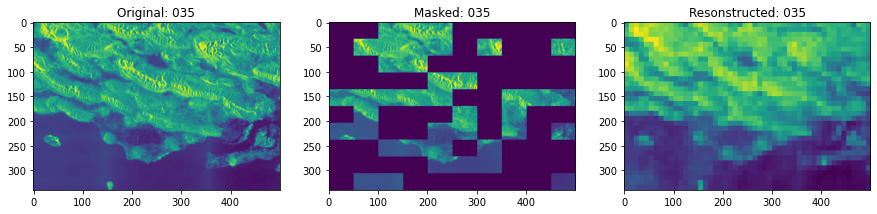

102/102 [==============================] - 43s 420ms/step - loss: 0.0078 - mae: 0.0601 - val_loss: 0.0070 - val_mae: 0.0570
Epoch 37/100
 39/102 [==========>...................] - ETA: 15s - loss: 0.0070 - mae: 0.0564

KeyboardInterrupt: 

In [20]:

history = mae_model.fit(
    data.train_ds, epochs=EPOCHS, validation_data=data.train_ds, callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(train_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")